
******************************************************************
Extended Kalman Filter (:class:`ekf <c4dynamics.filters.ekf.ekf>`)
******************************************************************



A linear Kalman filter 
(:class:`kalman <c4dynamics.filters.kalman.kalman>`) 
should be the first choice 
when designing a state observer. 
However, when a nominal trajectory cannot be found, 
the solution is to linearize the system
at each cycle about the current estimated state. 

Similarly to the linear Kalman filter, 
a good approach to design an extended Kalman filter 
is to separate it to two steps: `predict` and `update` (`correct`).

Since the iterative solution to the algebraic Riccati equation 
(uses to calculate the optimal covariance matrix :math:`P`) involves 
the matrix representation of the system parameters, the nonlinear equations
of the process and / or the measurement must be linearized 
before executing each stage of the `ekf`. 

Nevertheless, the calculation of the state vector :math:`x` 
both in the predict step (projection in time using the process equations) 
and in the update step (correction using the measure equations) 
does not have to use the approximated linear expressions (:math:`F, H`)
and can use the exact nonlinear equations (:math:`f, h`). 


Recall the mathematical model of a nonlinear system as given in :eq:`nonlinearmodel`:


.. math::

  \\dot{x} = f(x, u, \\omega) 

  y = h(x, \\nu) 

  x(0) = x_0 


Where: 

- :math:`f(\\cdot)` is an arbitrary vector-valued function representing the system dynamics
- :math:`x` is the system state vector 
- :math:`u` is the process input signal
- :math:`\\omega` is the process uncertainty with covariance matrix :math:`Q`
- :math:`y` is the system output vector 
- :math:`h(\\cdot)` is an arbitrary vector-valued function representing the system output
- :math:`\\nu` is the measure noise with covariance matrix :math:`R`
- :math:`x_0` is a vector of initial conditions  

The noise processes :math:`\\omega(t)` and :math:`\\nu(t)` are white, zero-mean, uncorrelated, 
and have known covariance matrices :math:`Q` and :math:`R`, respectively:

.. math::

  \\omega(t) \\sim (0, Q) 

  \\nu(t) \\sim (0, R) 

  E[\\omega(t) \\cdot \\omega^T(t)] = Q \\cdot \\delta(t) 

  E[\\nu(t) \\cdot \\nu^T(t)] = R \\cdot \\delta(t) 

  E[\\nu(t) \\cdot \\omega^T(t)] = 0 
    

Where:

- :math:`\\omega` is the process uncertainty with covariance matrix :math:`Q`
- :math:`\\nu` is the measure noise with covariance matrix :math:`R`
- :math:`Q` is the process covariance matrix 
- :math:`R` is the measurement covariance matrix 
- :math:`\\sim` is the distribution operator. :math:`\\sim (\\mu, \\sigma)` means a normal distribution with mean :math:`\\mu` and standard deviation :math:`\\sigma`
- :math:`E(\\cdot)` is the expectation operator 
- :math:`\\delta(\\cdot)` is the Dirac delta function (:math:`\\delta(t) = \\infty` if :math:`t = 0`, and :math:`\\delta(t) = 0` if :math:`t \\neq 0`)
- superscript T is the transpose operator


The linearized term for :math:`f` is given by its Jacobian with 
respect to :math:`x`: 

.. math::

  A = {\\partial{f} \\over \\partial{x}}\\bigg|_{x, u} 
  

Note however that the derivatives are taken at the last estimate  
(as opposed to a nominal trajectory that is used in a global linearization). 

The linearized term for :math:`h` is given by its Jacobian with 
respect to :math:`x`: 

.. math:: 

  C = {\\partial{h} \\over \\partial{x}}\\bigg|_{x} 
 

A last final step before getting into the filter itself 
is to discretize these terms: 


.. math::

  F = I + A \\cdot dt 

  H = C  


Where:

- :math:`F` is the discretized process dynamics matrix (actually a first order approximation of the state transition matrix :math:`\\Phi`)
- :math:`H` is the discrete measurement matrix 
- :math:`I` is the identity matrix
- :math:`dt` is the sampling time 
- :math:`A, C` are the continuous-time system dynamics and output matrices


Note that :math:`Q` and :math:`R` refer to the covariance matrices 
representing the system noise in its final form, regardless of the time domain.  


Now the execution of the `predict` step and the `update` step is possible. 


Predict
=======

As mentioned earlier, the advancement of the state vector 
is possible by using the exact equations. The second in 
the following equations is an Euler integration to the
nonlinear equations. 

The progression of the covariance matrix must use 
the linear terms that were derived earlier. 
The first equation in the following
set is the linearization of the process 
equations for the covariance calculation (third):


.. math:: 

  F = I + dt \\cdot {\\partial{f} \\over \\partial{x}}\\bigg|_{x_{k-1}^+, u{k-1}}

  x_k^- = x_{k-1}^+ + dt \\cdot f(x_{k-1}^+, u_{k-1})

  P_k^- = F \\cdot P_{k-1}^+ \\cdot F^T + Q

subject to initial conditions: 

.. math:: 
  
  x_0^+ = x_0

  P_0^+ = E[x_0 \\cdot x_0^T] 


Where: 

- :math:`F` is the discretized process dynamics matrix 
- :math:`I` is the identity matrix
- :math:`f(\\cdot)` is a vector-valued function representing the system dynamics
- :math:`dt` is the sampling time 
- :math:`x_k^-` is the estimate of the system state, :math:`x_k`, before a measurement update. 
- :math:`u_k` is the process input signal
- :math:`P_k^-` is the estimate of the system covariance matrix, :math:`P_k`, before a measurement update
- :math:`P_{k-1}^+` is the system covariance matrix estimate, :math:`P_k`, from previous measurement update 
- :math:`Q` is the process covariance matrix 
- superscript T is the transpose operator
- :math:`x_0` is the initial state estimation
- :math:`P_0` is the covariance matrix consisting of errors of the initial estimation 




Update
======

In a similar manner, the measurement equations :math:`h(x)` are 
linearized (:math:`H`) before the `update` to correct the covariance matrix. 
But the correction of the state vector is possible by using 
the nonlinear equations themselves (third equation): 


.. math:: 

  H = {\\partial{h} \\over \\partial{x}}\\bigg|_{x_k^-} 

  K = P_k^- \\cdot H^T \\cdot (H \\cdot P_k^- \\cdot H^T + R)^{-1}

  x_k^+ = x_k^- \\cdot K \\cdot (y - h(x)) 

  P_k^+ = (I - K \\cdot H) \\cdot P_k^-

Where:

- :math:`H` is the discrete measurement matrix 
- :math:`h(\\cdot)` is a vector-valued function representing the measurement equations 
- :math:`x_k^-` is the estimate of the system state, :math:`x_k`, from the previous prediction
- :math:`K` is the Kalman gain
- :math:`P_k^-` is the estimate of the system covariance matrix, :math:`P_k`, from the previous prediction
- :math:`R` is the measurement covariance matrix 
- :math:`x_k^+` is the estimate of the system state, :math:`x_k`, after a measurement update
- :math:`y` is the measure 
- :math:`I` is the identity matrix 
- :math:`P_k^+` is the estimate of the system covariance matrix, :math:`P_k`, after a measurement update
- superscript T is the transpose operator



Implementation (C4dynamics)
===========================

We saw that in both the 
`predict` and `update` stages, 
the state doesn't have 
to rely on approximated nonlinear equations 
but can instead 
use exact models for the process and the measurement. 
However, it is sometimes more convenient to use 
the existing linear for state advancements. 
C4dyanmics provides an interface for each approach:
the `predict` method 
can either take :math:`f(x)` 
as an input argument or use the necessary matrix :math:`F` 
to project the state in time. 
Similarly, the update method can either 
take :math:`h(x)` as an input argument 
or use the necessary matrix :math:`H`
to correct :math:`x`. 

Recall a few additional properties of  
filter implementation in 
c4dynamics, as described in the 
:ref:`linear kalman <kalman_implementation>` section: 

A. An Extended Kalman filter is a class.
The object holds the 
attributes required to build the estimates, and 
every method call relies on the results of previous calls. 

B. The Extended Kalman filter is a 
subclass of the state class. 
The state variables are part of the filter object itself, 
which inherits all the attributes of a state object.    

C. The filter operations
are divided into separate `predict` and `update` methods. 
:meth:`ekf.predict <c4dynamics.filters.ekf.ekf.predict>` 
projects the state into 
the next time. 
:meth:`ekf.update <c4dynamics.filters.ekf.ekf.update>` 
calculates the optimized gain and 
corrects the state based on the input measurement. 





Example
-------

The following example appears in several sources. 
[ZP]_ provides a great deal of detail. Additional sources can be found in [SD]_. 
The problem is to estimate the ballistic coefficient of a target 
in a free fall where a noisy radar is tracking it.

The process equations are: 

.. math:: 

  \\dot{z} = v_z

  \\dot{v}_z = {\\rho_0 \\cdot e^{-z / k} \\cdot v_z^2 \\cdot g \\over 2 \\cdot \\beta} - g

  \\dot{\\beta} = \\omega_{\\beta} 

  y = z + \\nu_k 


Where:


- :math:`\\rho_0 = 0.0034`
- :math:`k = 22,000` 
- :math:`g = 32.2 ft/sec^2`
- :math:`\\omega_{\\beta} \\sim (0, 300)`
- :math:`\\nu_k \\sim (0, 500)` 
- :math:`z` is the target altitude (:math:`ft`)
- :math:`v_z` is the target vertical velocity (:math:`ft/sec`)
- :math:`\\beta` is the target ballistic coefficient (:math:`lb/ft^2`)
- :math:`y` is the system measure 


Let:

.. math::

  \\rho = \\rho_0 \\cdot e^{-z / k}


The lineariztion of the process matrix for the `predict` step:

.. math::

  M = \\begin{bmatrix}
        0 & 1 & 0 \\\\
          -\\rho \\cdot g \\cdot v_z^2 / (44000 \\cdot \\beta) 
          & \\rho \\cdot g \\cdot v_z / \\beta
          & -\\rho \\cdot g \\cdot v_z^2 \\cdot / (2 \\cdot \\beta^2) \\\\ 
            0 & 0 & 0
      \\end{bmatrix}  

  
The measurement is a direct sample of the altitude of the target
so these equations are already a linear function of the state. 

.. math::

  H = \\begin{bmatrix}
        1 & 0 & 0 
      \\end{bmatrix}  
              

We now have all we need to run the extended Kalman filter. 
      

Quick setup for an ideal case: 

.. code:: 

  >>> dt, tf = .01, 30
  >>> tspan = np.arange(dt, tf, dt) 
  >>> dtsensor = 0.05  
  >>> rho0, k = 0.0034, 22000 
  >>> tgt = c4d.state(z = 100000, vz = -6000, beta = 500)
  >>> altmtr = c4d.sensors.radar(isideal = True, dt = dt)

Target equations of motion:

.. code:: 

  >>> def ballistics(y, t):
  ...   return [y[1], rho0 * np.exp(-y[0] / k) * y[1]**2 * c4d.g_fts2 / 2 / y[2] - c4d.g_fts2, 0]

  
Main loop: 

.. code::  

  >>> for t in tspan:
  ...   tgt.store(t)
  ...   tgt.X = odeint(ballistics, tgt.X, [t, t + dt])[-1]
  ...   _, _, z = altmtr.measure(tgt, t = t, store = True)

.. figure:: /_examples/filters/bal_ideal.png


These figures show the time histories of the altitude, velocity, 
and ballistic coefficient, for a target in a free fall with ideal conditions. 

Let's examine the `ekf` capability to estimate :math:`\\beta` at the presence of errors. 
Errors in initial conditions introduced into each one of the variables: 
:math:`z_{0_{err}} = 25, v_{z_{0_{err}}} = -150, \\beta_{0_{err}} = 300`. 
The uncertainty in the ballistic coefficient is given in terms of 
the spectral density of a continuous system, such that for flight time :math:`t_f`, 
the standard deviation of the ballistic coefficient noise 
is :math:`\\omega_{\\beta} = \\sqrt{\\beta_{err} \\cdot t_f}`. 
The measurement noise is :math:`\\nu = \\sqrt{500}`. These use 
for the noise covariance matrices :math:`Q, R` as for 
the initialization of the state covariance matrix :math:`P`:   


.. code::

  >>> zerr, vzerr, betaerr = 25, -150, 1000 
  >>> nu = np.sqrt(500) 
  >>> p0 = np.diag([nu**2, vzerr**2, betaerr**2])
  >>> R = nu**2 / dt
  >>> Q = np.diag([0, 0, betaerr**2 / tf * dt])  
  >>> # altmeter and ekf construction: 
  >>> altmtr = c4d.sensors.radar(rng_noise_std = nu, dt = dtsensor) 
  >>> ekf = c4d.filters.ekf(X = {'z': tgt.z + zerr, 'vz': tgt.vz + vzerr
  ...                                     , 'beta': tgt.beta + betaerr}
  ...                                         , P0 = p0, dt = dt) 



The main loop includes the simulation of the target motion, the linearization 
and discretization of the process equations, and calling the `predict` method. 
Then linearization and discretization of the measurement equations (not relevant 
here as the measurement is already linear), and calling the `update` method. 

.. code:: 

  >>> for t in tspan:
  ...   # target motion simulation  
  ...   tgt.X = odeint(ballistics, tgt.X, [t, t + dt])[-1]
  ...   # process linearization 
  ...   rhoexp = rho0 * np.exp(-ekf.z / k) * c4d.g_fts2 * ekf.vz / ekf.beta
  ...   fx = [ekf.vz, rhoexp * ekf.vz / 2 - c4d.g_fts2, 0]
  ...   f2i = rhoexp * np.array([-ekf.vz / 2 / k, 1, -ekf.vz / 2 / ekf.beta])
  ...   # discretization 
  ...   F = np.array([[0, 1, 0], f2i, [0, 0, 0]]) * dt + np.eye(3)
  ...   # ekf predict 
  ...   ekf.predict(F, Q, fx = fx)
  ...   # take a measure 
  ...   _, _, Z = altmtr.measure(tgt, t = t, store = True)
  ...   if Z is not None:  
  ...     H = [1, 0, 0]
  ...     # ekf update 
  ...     ekf.update(Z, H, R)
  ...   # store states
  ...   tgt.store(t)
  ...   ekf.store(t)

Though the `update` requires also the linear 
process matrix (:math:`F`), the `predict` method 
stores the introduced `F` to prove that 
the `update` step always comes after calling the `predict`. 


.. figure:: /_examples/filters/bal_filtered.png



A few steps to consider when designing a Kalman filter: 

- Spend some time understanding the dynamics. It's the basis of great filtering. 
- If the system is nonlinear, identify the nonlinearity; is it in the process? in the measurement? both? 
- Always prioriorotize linear Kalman. If possible, find a nominal trajectory to linearize the system about.
- The major time-consuming activity is researching the balance between the noise matrices `Q` and `R`.
- -> Plan your time in advance.
- Use a framework that provides you with the most flexibility and control.
- Make fun! 





z:\Dropbox\c4dynamics\docs\source\programs


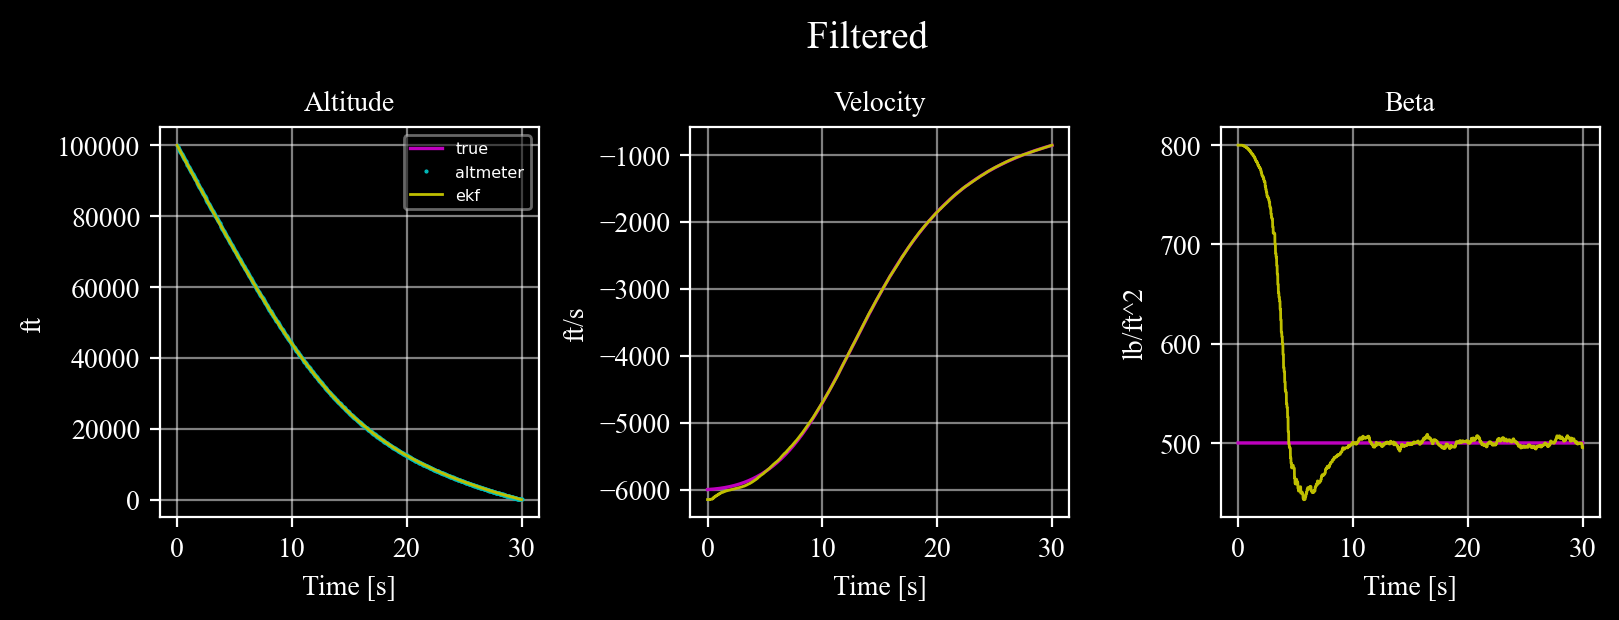

In [5]:
# type: ignore

import numpy as np 
from scipy.integrate import odeint 

from matplotlib import pyplot as plt 
plt.style.use('dark_background')  
# plt.switch_backend('TkAgg')

import os, sys
sys.path.append(r'../../../')
print(os.getcwd())
import c4dynamics as c4d 


savedir = os.path.join(c4d.c4dir(os.getcwd()), 'docs', 'source', '_examples', 'filters') 


dt, tf =  0.01, 30 # .05, 30 #
tspan = np.arange(0, tf + dt, dt)  
dtsensor = .05 # 0.1 # 





rho0 = .0034 
k = 22000 
nu = np.sqrt(500) 
zerr, vzerr, betaerr = 25, -150, 300 

def drawekf(ekf = None, trueobj = None, measures = None, title = '', filename = None, std = False): 

  from matplotlib.ticker import ScalarFormatter
  textsize = 10
  

  fig, ax = plt.subplots(1, 3, dpi = 200, figsize = (9, 3) # figsize = (8, 2) # 
                , gridspec_kw = {'left': .15, 'right': .95
                                  , 'top': .80, 'bottom': .15
                                    , 'hspace': 0.5, 'wspace': 0.4}) 

  fig.suptitle('                ' + title, fontsize = 14, fontname = 'Times New Roman')
  plt.subplots_adjust(top = 0.95)  # Adjust for suptitle space


  ''' altitude '''

  if trueobj: 
    ax[0].plot(*trueobj.data('z'), 'm', linewidth = 1.2, label = 'true') 
  
  if measures: 
    ax[0].plot(*measures.data('range'), '.c', markersize = 1, label = 'altmeter')

  if ekf:
    ax[0].plot(*ekf.data('z'), linewidth = 1, color = 'y', label = 'ekf')

  if std: 
    x = ekf.data('z')[1]
    t_sig, x_sig = ekf.data('P00')
    # ±std 
    ax[0].plot(t_sig, x + np.sqrt(x_sig.squeeze()), linewidth = 1, color = 'w', label = 'std') # np.array(v.color) / 255)
    ax[0].plot(t_sig, x - np.sqrt(x_sig.squeeze()), linewidth = 1, color = 'w') # np.array(v.color) / 255)
    # correct
    # ax[0].plot(t_sig[iscorrect], x[iscorrect], linewidth = 0, color = color
    #                       , marker = 'o', markersize = 2, markerfacecolor = 'none', label = 'correct') 

    # ax[0].set_ylim((995, 1012))



  c4d.plotdefaults(ax[0], 'Altitude', 'Time [s]', 'ft', textsize)
  ax[0].legend(fontsize = 'xx-small', facecolor = None, framealpha = .5)  #, edgecolor = None Set font size and legend box properties
  # xx-small, x-small, small, medium, large, x-large, xx-large, larger, smaller, None

  # ax[0].yaxis.set_major_formatter(ScalarFormatter())
  # ax[0].yaxis.get_major_formatter().set_useOffset(False)
  # ax[0].yaxis.get_major_formatter().set_scientific(False)



  ''' velocity '''

  if trueobj: 
    ax[1].plot(*trueobj.data('vz'), 'm', linewidth = 1.2, label = 'true') 

  if ekf:
    ax[1].plot(*ekf.data('vz'), linewidth = 1, color = 'y', label = 'ekf')

  if std: 
    x = ekf.data('vz')[1]
    t_sig, x_sig = ekf.data('P11') 
    # ±std 
    ax[1].plot(t_sig, (x + np.sqrt(x_sig.squeeze())), linewidth = 1, color = 'w', label = 'std') # np.array(v.color) / 255)
    ax[1].plot(t_sig, (x - np.sqrt(x_sig.squeeze())), linewidth = 1, color = 'w') # np.array(v.color) / 255)
    # state
    # ax[1].plot(t_sig[iscorrect], x[iscorrect] * c4d.r2d, linewidth = 0, color = 'w'
    #                     , marker = '.', markersize = 2, markerfacecolor = 'none', label = 'correct') 


  c4d.plotdefaults(ax[1], 'Velocity', 'Time [s]', 'ft/s', textsize)
  # ax[1].legend(fontsize = 'small', facecolor = None)




  ''' ballistic coefficient '''

  if trueobj: 
    ax[2].plot(*trueobj.data('beta'), 'm', linewidth = 1.2, label = 'true') # label = r'$\gamma$') #'\\gamma') # 

  if ekf:
    ax[2].plot(*ekf.data('beta'), linewidth = 1, color = 'y', label = 'ekf')

  if std: 
    x = ekf.data('beta')[1]
    t_sig, x_sig = ekf.data('P22')
    # ±std 
    ax[2].plot(t_sig, (x + np.sqrt(x_sig.squeeze())), linewidth = 1, color = 'w', label = 'std') # np.array(v.color) / 255)
    ax[2].plot(t_sig, (x - np.sqrt(x_sig.squeeze())), linewidth = 1, color = 'w') # np.array(v.color) / 255)
    # state
    # ax[1].plot(t_sig[iscorrect], x[iscorrect] * c4d.r2d, linewidth = 0, color = 'w'
    #                     , marker = '.', markersize = 2, markerfacecolor = 'none', label = 'correct') 


  c4d.plotdefaults(ax[2], 'Beta', 'Time [s]', 'lb/ft^2', textsize)

  # from matplotlib.transforms import Bbox
  # width_fig, height_fig = fig.get_size_inches()

  # # bbox = Bbox([[pad_left, pad_others], [1 - pad_others, 1 - pad_others]])
  # pad_left = .0001
  # bbox = Bbox.from_extents(# [left, bottom, right, top]
  #           pad_left * width_fig
  #             , pad_others * height_fig
  #               , (1 - pad_others) * width_fig
  #               , (1 - pad_others) * height_fig)  

  if filename: 
    plt.savefig(c4d.j(savedir, filename + '.png')
                    , pad_inches = .2, dpi = 600)








def ballistics(y, t):

  # altitude 
  # velocity 
  # ballistic coefficient 
 

  return [y[1], rho0 * np.exp(-y[0] / k) * y[1]**2 * c4d.g_fts2 / 2 / y[2] - c4d.g_fts2, 0]


def ideal():
  ''' ideal '''
  tgt = c4d.state(z = 100000, vz = -6000, beta = 500)
  altmtr = c4d.sensors.radar(isideal = True, dt = dtsensor)

  for t in tspan:
    tgt.store(t)
    
    tgt.X = odeint(ballistics, tgt.X, [t, t + dt])[-1]
    altmtr.measure(tgt, t = t, store = True)
    
  return tgt, altmtr
  

def noisy():
  ''' noisy no kalman ''' 
  tgt = c4d.state(z = 100000, vz = -6000, beta = 500)
  altmtr = c4d.sensors.radar(rng_noise_std = nu, dt = dtsensor)

  for t in tspan:
    tgt.store(t)

    tgt.X = odeint(ballistics, tgt.X, [t, t + dt])[-1]
    altmtr.measure(tgt, t = t, store = True)

  return tgt, altmtr
  

def filtered():
  ''' filtered ''' 
  tgt = c4d.state(z = 100000, vz = -6000, beta = 500)


  p0 = np.diag([nu**2, vzerr**2, betaerr**2]) # when a list is given the std are provided. when matrix the variances. 
  R = nu**2 / dt


  ''' sensor init '''
  altmtr = c4d.sensors.radar(rng_noise_std = nu, dt = dtsensor) 
  Q = np.diag([0, 0, betaerr**2 / tf * dt])  

  np.random.seed(1337)

  H = [1, 0, 0]
  ekf = c4d.filters.ekf(X = {'z': tgt.z + zerr, 'vz': tgt.vz + vzerr
                                  , 'beta': tgt.beta + betaerr}
                          , P0 = p0, H = H, Q = Q, R = R) 

  for t in tspan:

    ''' store the state '''
    tgt.store(t)
    ekf.store(t)

    tgt.X = odeint(ballistics, tgt.X, [t, t + dt])[-1]


    ''' 
    the necessary linear parameters for the predict stage: the 
    state transition matrix Phi (or its first order approximation F - the discreteized system matrix) 
    '''
    rhoexp  =   rho0 * np.exp(-ekf.z / k) * c4d.g_fts2 * ekf.vz / ekf.beta
    fx      =   [ekf.vz, rhoexp * ekf.vz / 2 - c4d.g_fts2, 0]
    f2i     =   rhoexp * np.array([-ekf.vz / 2 / k, 1, -ekf.vz / 2 / ekf.beta])
    F       =   np.array([[0, 1, 0], f2i, [0, 0, 0]]) * dt + np.eye(3)
    ekf.predict(F = F, fx = fx, dt = dt)


    ''' the necessary linear parameters for the predict stage: the measure matrix H '''
    _, _, Z = altmtr.measure(tgt, t = t, store = True)
    
    if Z is not None:  
      ekf.update(Z)




  return tgt, altmtr, ekf 


   
if __name__ == '__main__': 
  
  tgt1, altmtr = ideal()
  # drawekf(trueobj = tgt1, measures = altmtr, title = 'Ideal', filename = 'bal_ideal')

  tgt2, altmtr = noisy()
  # drawekf(trueobj = tgt2, measures = altmtr, title = 'Noisy')
  
  
  tgt, altmtr, ekf = filtered()
  drawekf(trueobj = tgt2, measures = altmtr, ekf =  ekf, title = 'Filtered', filename = 'bal_filtered')


  plt.show(block = True)







